### 1) Importing Libraries/Initialization

In [2]:
from flow.controllers import IDMController, ContinuousRouter, SimLaneChangeController, RLController
from flow.core.experiment import Experiment
from flow.core.params import SumoParams, EnvParams, InitialConfig, NetParams, VehicleParams
from flow.core.params import TrafficLightParams, SumoLaneChangeParams, SumoCarFollowingParams, InFlows

from crossing_network import crossingNetworkTemp_test, ADDITIONAL_NET_PARAMS2
from crossing_env4 import crossingEnv_4, ADDITIONAL_ENV_PARAMS

import torch.nn.functional as F
import torch as T

from flow.utils.registry import make_create_env
from datetime import datetime
#import logging
import time
import numpy as np
from Agent import agent, agent_2
import matplotlib.pyplot as plt 
import os

/home/giacomo/anaconda3/envs/flow/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
#vehicles
vehicles = VehicleParams()
vehicles.add(veh_id="human",
             acceleration_controller=(IDMController, {}),
             routing_controller=(ContinuousRouter, {}),
             lane_change_controller=(SimLaneChangeController, {}),
             car_following_params=SumoCarFollowingParams(speed_mode=31), #speed_mode="obey_safe_speed" 
             lane_change_params=SumoLaneChangeParams(lane_change_mode=1621), #model="SL2015",lc_sublane=2.0 ),
             num_vehicles=0)


inflow = InFlows()

edges = ["EC", "NC", "SC", "WC"]
vehrate_EW, vehrate_NS = 500, 850 #600-1000  400-750  500-850

inflow.add(veh_type="human", edge=edges[0], depart_lane="best", vehs_per_hour=vehrate_EW) #probability=0.2) #400 o 600 (high) to 500(med)

inflow.add(veh_type="human", edge=edges[1], depart_lane="best", vehs_per_hour=vehrate_NS) #750 to 1000 (high) to 850 (med)

inflow.add(veh_type="human", edge=edges[2], depart_lane="best", vehs_per_hour=vehrate_NS)

inflow.add(veh_type="human", edge=edges[3], depart_lane="best", vehs_per_hour=vehrate_EW) 


path = "/home/giacomo/tesi/tesi_giacomo/junction_github/std_crossroad3.net.xml"
additional_net_params = ADDITIONAL_NET_PARAMS2.copy()
net_params_temp = NetParams(inflows=inflow,  template={'net':path}, additional_params=additional_net_params) #'vtype':path_rou 'rou':path_rou

tl_logic = TrafficLightParams()


In [15]:
#NS: 250 (low) 500 (medium) 1000 (high)
#ES: 150 (low) 300 (medium) 600 (high)
ADDITIONAL_ENV_PARAMS['pedrate_EW'] = 300 #150
ADDITIONAL_ENV_PARAMS['pedrate_NS'] = 500 #250

ADDITIONAL_ENV_PARAMS['reward_function'] = 'waiting_time' #'queue_length'
ADDITIONAL_ENV_PARAMS['factor']=0

ADDITIONAL_ENV_PARAMS['green_duration']=10

ADDITIONAL_ENV_PARAMS

{'yellow_duration': 5,
 'green_duration': 10,
 'tl_type': 'controlled',
 'reward_function': 'waiting_time',
 'factor': 0,
 'pedrate_EW': 300,
 'pedrate_NS': 500}

In [16]:
sim_params = SumoParams(sim_step=1,  render="drgb",
                        restart_instance=True, color_by_speed=True, emission_path="./res_prova")

env_params = EnvParams(additional_params=ADDITIONAL_ENV_PARAMS, horizon = 2000)

initial_config = InitialConfig()

flow_params = dict(
    exp_tag='crossing_ped_test2',
    env_name=crossingEnv_4,
    network=crossingNetworkTemp_test, #
    simulator='traci',
    sim=sim_params,
    env=env_params,
    net=net_params_temp, #2,
    veh=vehicles,
    initial=initial_config,
    tls=tl_logic
)

In [6]:
print(f"Inflows lvl: {set([i['vehsPerHour'] for i in flow_params['net'].inflows.get()])}")

Inflows lvl: {600, 1000}


In [7]:
flow_params['env'].additional_params

{'yellow_duration': 5,
 'green_duration': 10,
 'tl_type': 'controlled',
 'reward_function': 'waiting_time',
 'factor': 0,
 'pedrate_EW': 300,
 'pedrate_NS': 500}

### 2) Training

In [9]:
max_steps = flow_params['env'].horizon
start_timesteps = 1000
yellow_duration = flow_params['env'].additional_params['yellow_duration']
green_duration = flow_params['env'].additional_params['green_duration']

best_return = -1e8

info_dict = {
    "ret_full":[],
    "returns": [],
}

flow_params['sim'] = SumoParams(sim_step=1, render=False, seed=42, restart_instance=True, color_by_speed=True) #, emission_path="./res_prova" )

###  AGENT INITIALIZATION

## From zero
TL_agent = agent_2(input_dims=32, gamma=0.99, epsilon=0.4, lr=0.001, eps_dec=4e-5, replace=100,  batch_size=128, n_actions=3) #input_dims = 32 for wt and delay, 29 for queue_len  #for advandced update eps .1 dec 5e-8 replace 200 bs 256

## Uploaded
#params = T.load('results/mod_ped/mod_mixlow_10_ql', map_location=T.device('cpu')) ##mod_mix_10_ql_pen200 mod_ql_STD #mod_ql_mixlarge
#TL_agent.model.load_state_dict(params)
#TL_agent.q_next.load_state_dict(params) 

#TL_agent.epsilon = 0.4
#TL_agent.eps_dec = 4e-5
#TL_agent.lr=0.003

###

create_env, _ = make_create_env(flow_params)
env = create_env()
env.beta = 0.5
pen = 10

print(f'----- \nInfo \nGreen: {green_duration} \nVeh rate: {[i["vehsPerHour"] for i in flow_params["net"].inflows.get()]} \nbeta: {env.beta} \npen: {pen} \n-----')

for ep in range(1, 200):
    
    # PUT IN ENV.RESET
    env.temp_vehs = {}
    env.temp_ped = {}
    env.curr_step = 0 
    
    state = env.reset()

    old_action =  None
    done = False
    returns = 0
    #prev_wait_time = 0
    env.curr_step = 0
    #prev_step = 0 #for replace network
   
    actions = []
    cd = 0

    tempveh = []
    tempped = []

    while env.curr_step<max_steps:

        
        ## SET PHASE
        if ep==0 and env.curr_step < start_timesteps:  
            action = None 
        else:
            action = TL_agent.select_action(state)
     
            yellow_reward = 0
                
            if old_action!= None and old_action != action:
                env._set_yellow_phase()
                _, yellow_reward, _ = env.run_sim2(yellow_duration)

            env._set_green_phase(action)
        
        ## RUN SIM
        new_state, reward, done = env.run_sim2(green_duration)

        ## PENALTY MECHANISM
        actions.append(action)
        if set(actions[-3:])=={0,1,2}:
            cd+=1
            reward -=pen
   
        ## STORE/UPDATE INFO and TRAIN
        if ep>0 or env.curr_step > start_timesteps:
            reward += yellow_reward
            TL_agent.memory.store_transition(state, action, reward, new_state, done)
            TL_agent.train(green_duration)

        returns += reward
        state = new_state
        old_action = action

        ## SAVE METRICS
        tempveh.append(env.waiting_time())
        tempped.append(sum(env.temp_ped.values())/len(env.temp_ped) if len(env.temp_ped)>0 else 0)


    info_dict['returns'].append(returns)   
    print('avg res:', np.mean(tempped), np.mean(tempveh))
    
    if env.curr_step>max_steps-1:
        info_dict["ret_full"].append(returns)
        if returns>best_return:
            #TL_agent.model.save_checkpoint()
            best_return = returns
            mod = TL_agent.model.state_dict()


    if ep%20==0 and ep>0:
        print(f"### Episode {ep} - Total Returns: {returns:.3f}")
        t=info_dict['ret_full']
        plt.plot(np.arange(len(t)), t)#[0:80])
        plt.show()

    #print(f"### Episode {ep} - Total Returns: {returns:.3f}, cd {cd}")


t=info_dict['ret_full']
plt.plot(np.arange(len(t)), t)#[0:80])
plt.show()


env.terminate()

print(f'----- \nInfo \nGreen: {green_duration} \nVeh rate: {[i["vehsPerHour"] for i in flow_params["net"].inflows.get()]} \nbeta: {env.beta} \npen: {pen} \n-----')

import time
print("Ora di completamento:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

----- 
Info 
Green: 10 
Veh rate: [600, 1000, 1000, 600] 
beta: 0.5 
pen: 10 
-----
avg res: 104.37776838747193 9379.702380952382


KeyboardInterrupt: 

In [ ]:
### SAVE MODEL
import os
T.save(TL_agent.model.state_dict(), os.path.join('results/mod_ped', '...'))

### 3) Agent evaluation

In [12]:
fg = T.load('results/mod_ped/mod_wt_mid_10_5', map_location=T.device('cpu'))

TL_agent = agent_2(input_dims=32, gamma=0.99, epsilon=0.01, n_actions=3) 
TL_agent.model.load_state_dict(fg)
TL_agent.q_next.load_state_dict(fg)


<All keys matched successfully>

In [17]:
max_steps = flow_params['env'].horizon
start_timesteps = 1000
yellow_duration = flow_params['env'].additional_params['yellow_duration']
green_duration = flow_params['env'].additional_params['green_duration']

stats = {}

flow_params['sim'] = SumoParams(sim_step=1, render=False, seed=42, restart_instance=True, color_by_speed=True)

create_env, _ = make_create_env(flow_params)
env = create_env()
env.beta = 0.5
pen = 10

print(f'----- \nInfo \nGreen: {green_duration} \nVeh rate: {[i["vehsPerHour"] for i in flow_params["net"].inflows.get()]} \nbeta: {env.beta} \npen: {pen} \n-----')

for episode in range(10):

    env.temp_vehs = {}
    env.temp_ped = {}
    env.curr_step = 0 

    state = env.reset()
    
    old_action =  None
    done = False
    returns = 0
    prev_wait_time = 0
    env.curr_step = 0

    info_dict = {
    "wt_ped":[],
    "wt_veh":[],
    "wt_veh_ind":[],
    "queue":[],
    "delay":[],
    "actions":[],
    "ret":[],
    "wt_ped_tot":[]
}   

    while env.curr_step<max_steps: #for step in range(max_steps):  
        
        #print(f'\n### STEP {env.curr_step}')
        
        action = TL_agent.select_action(state) #None 

        yellow_reward = 0
            
        if old_action!= None and old_action != action:
            env._set_yellow_phase()
            _, yellow_reward, _ = env.run_sim2(yellow_duration)
            env._set_green_phase(action)
    
        new_state, reward, done = env.run_sim2(green_duration)


        #PENALIZE
        info_dict['actions'].append(action)
        if set(info_dict['actions'][-5:])=={0,1,2}:
            reward -=pen

        reward += yellow_reward

        info_dict['wt_ped'].append(sum(env.temp_ped.values())/len(env.temp_ped) if len(env.temp_ped)>0 else 0)

        vehs = []
        for edge in env.edges: #self.k.network.get_edge_list():
            vehs.extend(env.veh_set(edge)) 
        
        info_dict['wt_veh'].append(env.waiting_time())
        info_dict['wt_veh_ind'].append(env.waiting_time()/len(vehs) if len(vehs)>0 else 0)
        info_dict['queue'].append(env.queue_length())
        info_dict['delay'].append(env.avg_delay())
        info_dict['wt_ped_tot'].append(sum(env.temp_ped.values()))

        returns += reward
        state = new_state
        old_action = action

    print(f'{episode} ret: {returns} veh: {np.mean(info_dict["wt_veh"])} ped: {np.mean(info_dict["wt_ped"])} queue: {np.mean(info_dict["queue"])}')
    
    info_dict['ret'].append(returns)
    stats[episode] = info_dict


env.terminate()

import time


----- 
Info 
Green: 10 
Veh rate: [500, 850, 850, 500] 
beta: 0.5 
pen: 10 
-----
0 ret: -14706.224999999999 veh: 780.4154929577464 ped: 17.886150234741784 queue: 107.39207107855471
1 ret: -9165.424999999994 veh: 477.5390070921986 ped: 16.048125633232015 queue: 70.34865399065058


2 ret: -12406.7 veh: 632.6241134751773 ped: 17.35241472475515 queue: 86.13444921010851
3 ret: -8438.099999999997 veh: 379.34751773049646 ped: 17.47306653157717 queue: 56.376355662179535
4 ret: -11069.574999999999 veh: 537.6713286713286 ped: 17.592074592074596 queue: 77.87471115860484
5 ret: -12450.324999999993 veh: 623.7872340425532 ped: 16.822610604525497 queue: 79.25790805963167
6 ret: -9791.399999999994 veh: 539.6736111111111 ped: 19.289930555555557 queue: 76.49536853789617
7 ret: -13102.674999999997 veh: 662.8819444444445 ped: 21.48396164021164 queue: 93.66816565221633
8 ret: -11603.350000000002 veh: 592.936170212766 ped: 17.767350557244175 queue: 86.16390166450627
9 ret: -6615.549999999997 veh: 260.5931034482759 ped: 21.572906403940888 queue: 40.78942362990073


In [18]:
### DISPLAYING AVGs
 
dd = []
for i in range(0,9):
    dd+=[np.mean(stats[i]['wt_veh'])]
print("wt veh: ", np.mean(dd))

dd = []
for i in range(0,9):
    dd+=[np.mean(stats[i]['wt_ped_tot'])]
print("wt ped tot:", np.mean(dd))

dd = []
for i in range(0,9):
    dd+=[np.mean(stats[i]['wt_ped'])]
print("wt ped ind:", np.mean(dd))

dd = []
for i in range(0,9):
    dd+=[np.mean(stats[i]['queue'])]
print("queue:", np.mean(dd))

dd = []
for i in range(0,9):
    dd+=[np.mean(stats[i]['delay'])]
print("delay:", np.mean(dd))

wt veh:  580.7640466375358
wt ped tot: 283.67103667835363
wt ped ind: 17.96840945265751
queue: 81.52350944603874
delay: 22.917488722975925


In [124]:
### SAVE STATS
import pandas as pd
pd.DataFrame(stats).to_csv('results/stats_ped/...', index=True)

### SAVE MODEL
import os
T.save(TL_agent.model.state_dict(), os.path.join('results/mod_ped', '...'))

In [ ]:
#############################################

### 4) Training - Mixed Flows

In [63]:
def fase(ep):
    dz = {0: (400, 750), 1:(500, 850), 2:(600,1000) }
    return dz[ep%3]
    
def flow_mod(inflow, EWrate, NSrate):
    '''
    Used to modify the magnitude of vehicle flow
    '''
    for i in inflow.get():
        if i['edge']=='EC' or i['edge']=='WC':
            i['name'] = "flow_" + str(np.random.randint(1,1000000))
            i['vehsPerHour'] = EWrate
        else:
            i['name'] = "flow_" + str(np.random.randint(1,1000000))
            i['vehsPerHour'] = NSrate

    return None

In [65]:
chkpt = T.load('results/mod_ped/mod_ql_mixlarge', map_location=T.device('cpu')) #mod_mixlow_10_ql #mod_ql_STD_pen60

In [ ]:
print(f"Inflows lvl: {set([i['vehsPerHour'] for i in flow_params['net'].inflows.get()])}")

### Episode 1 - Total Returns: -13394.827
### Episode 2 - Total Returns: -29661.915
### Episode 3 - Total Returns: -8094.180
### Episode 4 - Total Returns: -19696.580
### Episode 5 - Total Returns: -31500.840
### Episode 6 - Total Returns: -8250.860
### Episode 7 - Total Returns: -12160.095
### Episode 8 - Total Returns: -27534.529
### Episode 9 - Total Returns: -8974.078
### Episode 10 - Total Returns: -12663.668
### Episode 11 - Total Returns: -26398.294
### Episode 12 - Total Returns: -9871.260


### Episode 13 - Total Returns: -14688.119
### Episode 14 - Total Returns: -26086.498
### Episode 15 - Total Returns: -8212.739


### Episode 16 - Total Returns: -12077.095
### Episode 17 - Total Returns: -25706.189
### Episode 18 - Total Returns: -7899.859
### Episode 19 - Total Returns: -13004.377


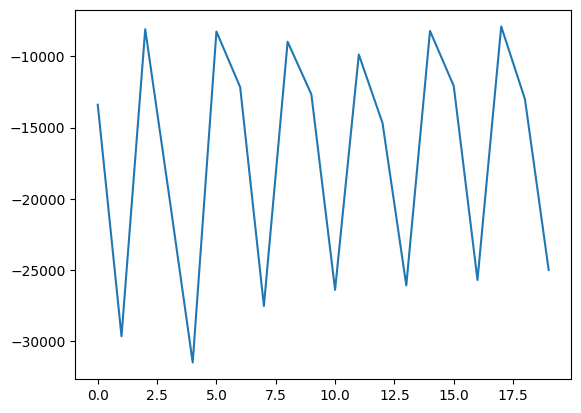

### Episode 20 - Total Returns: -25002.561
### Episode 21 - Total Returns: -7312.247
### Episode 22 - Total Returns: -12778.669
### Episode 23 - Total Returns: -24971.978
### Episode 24 - Total Returns: -8266.253
### Episode 25 - Total Returns: -11641.992
### Episode 26 - Total Returns: -25735.567
### Episode 27 - Total Returns: -8039.763
### Episode 28 - Total Returns: -14542.875
### Episode 29 - Total Returns: -24678.200
### Episode 30 - Total Returns: -8231.654
### Episode 31 - Total Returns: -10606.206
### Episode 32 - Total Returns: -24392.696
### Episode 33 - Total Returns: -7958.316
### Episode 34 - Total Returns: -12286.623
### Episode 35 - Total Returns: -23715.013
### Episode 36 - Total Returns: -8547.751
### Episode 37 - Total Returns: -11258.327
### Episode 38 - Total Returns: -24255.951


### Episode 39 - Total Returns: -7041.112


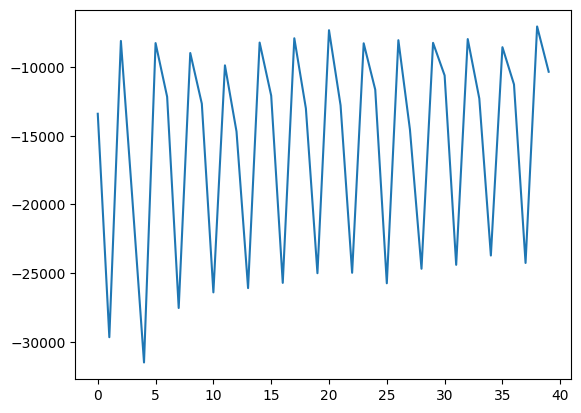

### Episode 40 - Total Returns: -10336.839
### Episode 41 - Total Returns: -23597.413
### Episode 42 - Total Returns: -6444.208
### Episode 43 - Total Returns: -10702.758
### Episode 44 - Total Returns: -22010.192
### Episode 45 - Total Returns: -6742.297
### Episode 46 - Total Returns: -9571.440
### Episode 47 - Total Returns: -24662.232
### Episode 48 - Total Returns: -6328.459
### Episode 49 - Total Returns: -10013.591
### Episode 50 - Total Returns: -27258.489
### Episode 51 - Total Returns: -7732.187
### Episode 52 - Total Returns: -11752.454
### Episode 53 - Total Returns: -26078.682
### Episode 54 - Total Returns: -6671.471
### Episode 55 - Total Returns: -9797.702
### Episode 56 - Total Returns: -25105.557
### Episode 57 - Total Returns: -7542.854
### Episode 58 - Total Returns: -10123.675
### Episode 59 - Total Returns: -23372.509


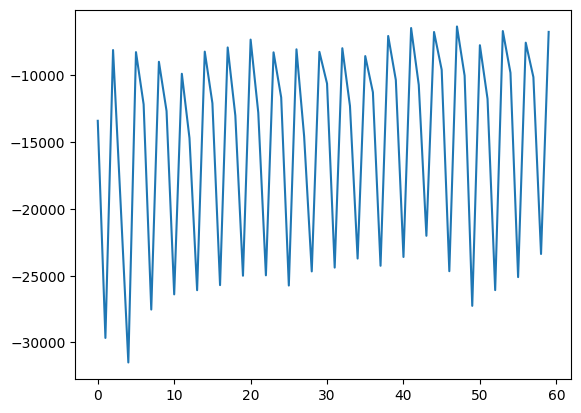

### Episode 60 - Total Returns: -6734.532
### Episode 61 - Total Returns: -10003.068
### Episode 62 - Total Returns: -21255.585
### Episode 63 - Total Returns: -7078.231
### Episode 64 - Total Returns: -9658.676
### Episode 65 - Total Returns: -23581.006
### Episode 66 - Total Returns: -6294.758
### Episode 67 - Total Returns: -8746.108
### Episode 68 - Total Returns: -22956.050
### Episode 69 - Total Returns: -6218.112
### Episode 70 - Total Returns: -9059.953
### Episode 71 - Total Returns: -21846.658
### Episode 72 - Total Returns: -6981.400
### Episode 73 - Total Returns: -9834.489
### Episode 74 - Total Returns: -24881.244
### Episode 75 - Total Returns: -7498.473
### Episode 76 - Total Returns: -10519.639
### Episode 77 - Total Returns: -22052.833
### Episode 78 - Total Returns: -6635.346
### Episode 79 - Total Returns: -9674.439


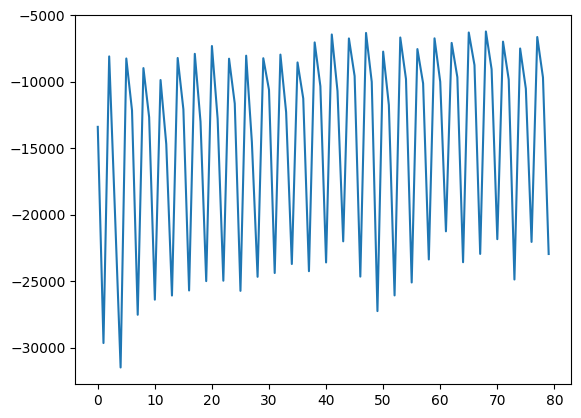

### Episode 80 - Total Returns: -22962.026
### Episode 81 - Total Returns: -6941.537
### Episode 82 - Total Returns: -10111.623
### Episode 83 - Total Returns: -26623.420
### Episode 84 - Total Returns: -7151.558
### Episode 85 - Total Returns: -9185.108
### Episode 86 - Total Returns: -23045.803
### Episode 87 - Total Returns: -6826.198
### Episode 88 - Total Returns: -9039.637
### Episode 89 - Total Returns: -23721.384
### Episode 90 - Total Returns: -6995.164
### Episode 91 - Total Returns: -10236.221
### Episode 92 - Total Returns: -22406.292
### Episode 93 - Total Returns: -7682.454
### Episode 94 - Total Returns: -9136.045
### Episode 95 - Total Returns: -22158.925
### Episode 96 - Total Returns: -7186.390
### Episode 97 - Total Returns: -8498.795
### Episode 98 - Total Returns: -20499.859
### Episode 99 - Total Returns: -6457.574


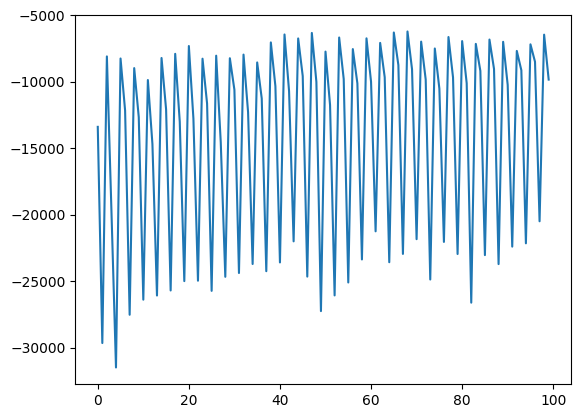

### Episode 100 - Total Returns: -9839.120
### Episode 101 - Total Returns: -22045.576
### Episode 102 - Total Returns: -6740.346
### Episode 103 - Total Returns: -8924.564
### Episode 104 - Total Returns: -22405.139
### Episode 105 - Total Returns: -6918.953
### Episode 106 - Total Returns: -9486.117
### Episode 107 - Total Returns: -26023.043
### Episode 108 - Total Returns: -6712.483
### Episode 109 - Total Returns: -9915.897
### Episode 110 - Total Returns: -21170.086
### Episode 111 - Total Returns: -7651.533
### Episode 112 - Total Returns: -10708.851
### Episode 113 - Total Returns: -24074.823
### Episode 114 - Total Returns: -7315.847
### Episode 115 - Total Returns: -10131.145
### Episode 116 - Total Returns: -20034.240
### Episode 117 - Total Returns: -7403.505
### Episode 118 - Total Returns: -10434.167
### Episode 119 - Total Returns: -21436.071


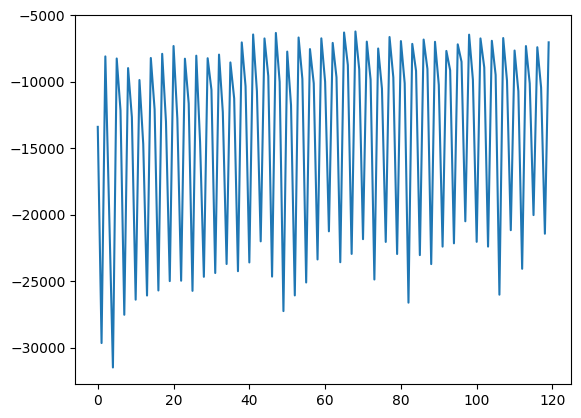

### Episode 120 - Total Returns: -7035.335
### Episode 121 - Total Returns: -9434.665
### Episode 122 - Total Returns: -21752.956
### Episode 123 - Total Returns: -7582.299


### Episode 124 - Total Returns: -9739.479
### Episode 125 - Total Returns: -24543.713
### Episode 126 - Total Returns: -7129.862
### Episode 127 - Total Returns: -9727.218
### Episode 128 - Total Returns: -23317.952
### Episode 129 - Total Returns: -7395.903
### Episode 130 - Total Returns: -10345.598
### Episode 131 - Total Returns: -21719.130
### Episode 132 - Total Returns: -7054.064
### Episode 133 - Total Returns: -8625.764
### Episode 134 - Total Returns: -22840.691
### Episode 135 - Total Returns: -7149.962
### Episode 136 - Total Returns: -9191.549
### Episode 137 - Total Returns: -23690.842
### Episode 138 - Total Returns: -6952.274
### Episode 139 - Total Returns: -10294.945


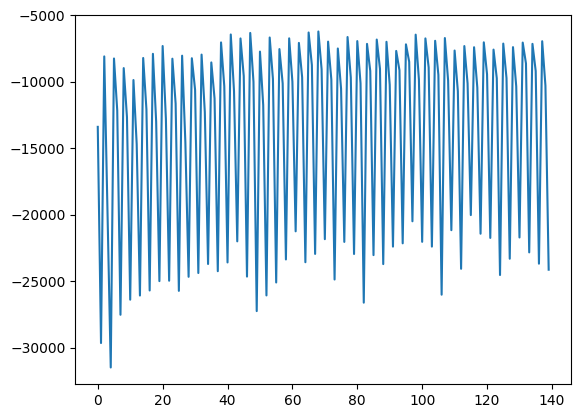

### Episode 140 - Total Returns: -24143.410
### Episode 141 - Total Returns: -6745.347
### Episode 142 - Total Returns: -8810.458
### Episode 143 - Total Returns: -22390.955
### Episode 144 - Total Returns: -7099.675
### Episode 145 - Total Returns: -8969.930
### Episode 146 - Total Returns: -21809.329
### Episode 147 - Total Returns: -7502.176
### Episode 148 - Total Returns: -9639.223
### Episode 149 - Total Returns: -21304.220


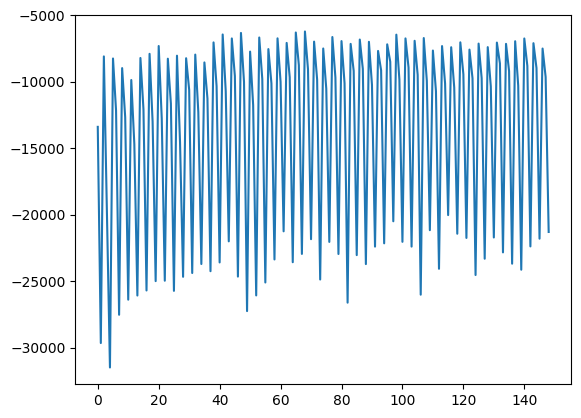

In [67]:
max_steps = flow_params['env'].horizon
start_timesteps = 1000
yellow_duration = flow_params['env'].additional_params['yellow_duration']
green_duration = flow_params['env'].additional_params['green_duration']
best_return = -1e8

info_dict = {
    "ret_full":[],
    "returns": [],
}

flow_params['sim'] = SumoParams(sim_step=1, render=False, seed=42, restart_instance=True, color_by_speed=True) 

TL_agent = agent_2(input_dims=29, gamma=0.99, epsilon=0.4, lr=0.001, eps_dec=4e-5, replace=200,  batch_size=128, n_actions=3, mem_size=20000)  
TL_agent.model.load_state_dict(chkpt)
#TL_agent.epsilon = 0.4
#TL_agent.eps_dec = 1e-4 #5e-7
#TL_agent = b

print(f'----- \nInfo \nGreen: {green_duration} \nVeh rate: {[i["vehsPerHour"] for i in flow_params["net"].inflows.get()]} \nbeta: {env.beta} \npen: {pen} \n-----')

for ep in range(1, 150):

    a,b = fase(ep)
    flow_mod(inflow, a, b)
    flow_params['net'] = NetParams(inflows=inflow,  template={'net':path}, additional_params=additional_net_params)

    create_env, _ = make_create_env(flow_params)
    env = create_env()
     
    # PUT IN ENV.RESET
    env.temp_vehs = {}
    env.temp_ped = {}

    state = env.reset()

    old_action =  None
    done = False
    returns = 0
    env.curr_step = 0 
    env.beta = 0.5

    actions = []

    pen = 30
    cd = 0

    while env.curr_step<max_steps: 

        #print(f'\n### STEP {env.curr_step}')
        
        if ep==0 and env.curr_step < start_timesteps:  
            action = None 
        else:
            action = TL_agent.select_action(state)
            
            yellow_reward = 0
                
            if old_action!= None and old_action != action:
                env._set_yellow_phase()
               
                _, yellow_reward, _ = env.run_sim2(yellow_duration)

            env._set_green_phase(action)
        
        new_state, reward, done = env.run_sim2(green_duration)

        actions.append(action)
        if set(actions[-3:])=={0,1,2}:
            reward -=pen
            cd+=1


        if ep>0 or env.curr_step > start_timesteps:
            reward += yellow_reward
            TL_agent.memory.store_transition(state, action, reward, new_state, done)
            TL_agent.train(green_duration)


        returns += reward
        state = new_state
        old_action = action


    env.terminate()

    info_dict['returns'].append(returns)   
    
    if env.curr_step>max_steps-1:
        info_dict["ret_full"].append(returns)
        if returns>best_return:
            best_return = returns
            mod = TL_agent.model.state_dict()


    if ep%20==0 and ep>0:
        t=info_dict['ret_full']
        plt.plot(np.arange(len(t)), t)
        plt.show()

    print(f"### Episode {ep} - Total Returns: {returns:.3f}")


t=info_dict['ret_full']
plt.plot(np.arange(len(t)), t)#[0:80])
plt.show()


In [ ]:
import os
import pandas as pd
#pd.DataFrame(stats).to_csv('results/stats_ped/...', index=True)
#T.save(TL_agent.model.state_dict(), os.path.join('results/mod_ped', '...'))